# ** DIscBIO: a user-friendly pipeline for biomarker discovery in single-cell transcriptomics**

# CONQUER Notebook

CONQUER is a collection of analysis-ready public scRNA-seq data sets. It can be reached through their home page: http://imlspenticton.uzh.ch:3838/conquer/

DIscBIO consists of four successive steps: data pre-processing, cellular clustering and pseudo-temporal ordering, determining differential expressed genes and identifying biomarkers.

![DIsccBIO](DiscBIO.png)

## Required Packages

In [1]:
library(MultiAssayExperiment)
library(SummarizedExperiment)
library(DIscBIO)
library(partykit)
library(enrichR)

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.ma

## Loading dataset

To use a data set provided in the conquer database, download the corresponding R object into your current working directory.
Here we will be using the GSE41265 dataset as an example. 

"Single-cell transcriptomics reveals bimodality in expression and splicing in immune cells"     
DOI: 10.1038/nature12172

Organism: Mus musculus


In [2]:
GSE41265 <- readRDS("GSE41265.rds")
Dataset=assays(experiments(GSE41265)[["gene"]])[["count"]]
rownames(Dataset) <- as.list(sub("*\\..*", "", unlist(rownames(Dataset))))   #### To adjust the gene Ensembl id
cat(paste0("This dataset contains:","\n","Genes: ",length(Dataset[,1]),"\n","cells: ",length(Dataset[1,]),"\n"))

This dataset contains:
Genes: 45686
cells: 18


In [3]:
sc<- DISCBIO(Dataset)       # The DISCBIO class is the central object storing all information generated throughout the pipeline 

## 1. Data Pre-processing

Prior to applying data analysis methods, it is standard to pre-process the raw read counts resulted from the sequencing. The preprocessing approach depends on the existence or absence of ERCC spike-ins. In both cases, it includes normalization of read counts and gene filtering. 

#### Normalization of read counts
To account for RNA composition and sequencing depth among samples (single-cells), the normalization method “median of ratios” is used. This method takes the ratio of the gene instantaneous median to the total counts for all genes in that cell (column median). The gene instantaneous median is the product of multiplying the median of the total counts across all cells (row median) with the read of the target gene in each cell. This normalization method makes it possible to compare the normalized counts for each gene equally between samples.

#### Gene filtering
The key idea in filtering genes is to appoint the genes that manifest abundant variation across samples. Filtering genes is a critical step due to its dramatic impact on the downstream analysis. In case the raw data includes ERCC spike-ins, genes will be filtered based on variability in comparison to a noise level estimated from the ERCC spike-ins according to an algorithm developed by Brennecke et al (Brennecke et al., 2013). This algorithm utilizes the dependence of technical noise on the average read count and fits a model to the ERCC spike-ins. Further gene filtering can be implemented based on gene expression.
In case the raw data does not include ERCC spike-ins, genes will be only filtered based on minimum expression in certain number of cells.


![DataPre-processing](Data-Preprocessing.png)

#### Checking the ERCC spike-ins

In [4]:
ERCC<-subset(sc@expdataAll, grepl('^ERCC-', rownames(sc@expdataAll)))
cat(paste0("This dataset contains ",length(ERCC[,1])," ERCC spike-ins.", "\n"))
S<-summary(rowMeans(ERCC,na.rm=TRUE))            # It gives an idea about the overall expression of the ERCCs
cat(paste0("Here is a summary of the expression of the ERCCs across cells: ", "\n"))
print(S)   

This dataset contains 92 ERCC spike-ins.
Here is a summary of the expression of the ERCCs across cells: 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1017  0.0000  9.3597 


### 1.2. Filtering and normalizing the raw data (not based on the ERCCs)

To normalize and filter the raw data we use the function Normalizedata() by giving the parameters minexpr and minnumber some values. This function will discard cells with less than mintotal transcripts. Genes that are not expressed at minexpr transcripts in at least minnumber cells are discarded. Furthermore, it will normalize the count reads using the normalization method “median of ratios”.
          
To Finalize the preprocessing the function FinalPreprocessing() should be implemented by setting the parameter "GeneFlitering" to ExpF.

In [5]:
# Estimating a value for the "minexpr" parameter
withoutERCC<-subset(sc@expdataAll, grepl('^ENS', rownames(sc@expdataAll)))
cat(paste0("This dataset contains ",length(withoutERCC[,1])," genes", "\n"))

S<-summary(rowMeans(withoutERCC,na.rm=TRUE))            # It gives an idea about the overall expression of the genes
print(S)                                                 
minexpr= S[4]                                       # S2[3] is referring to the median whereas S2[4] is referring to the mean

This dataset contains 45594 genes
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
     0.0      0.0      0.1    408.2     35.3 473333.4 


In [6]:
# Estimating a value for the "minnumber" parameters
minnumber= round(length(Dataset[1,])*.3)                             # To be expressed in at 30% of the cells.
print(minnumber)

[1] 5


In [7]:
sc<-Normalizedata(sc, mintotal=1000, minexpr=minexpr, minnumber=minnumber, maxexpr=Inf, downsample=FALSE, dsn=1, rseed=17000) 
sc<-FinalPreprocessing(sc,GeneFlitering="ExpF",export = TRUE)        # The GeneFiltering should be set to "ExpF"

The gene filtering method = Noise filtering

The Filtered Normalized dataset contains:
Genes: 4232
cells: 18



The Filtered Normalized dataset was saved as: filteredDataset.Rdata



## 2. Cellular Clustering and Pseudo Time ordering

Cellular clustering is performed according to the gene expression profiles to detect cellular sub-population with unique properties. After clustering, pseudo-temporal ordering is generated to indicate the cellular differentiation degree. 

![PSCAN](Clustering.png)

## 2.1. K-means Clustering

Rare cell type Identification algorithm (RaceID) was used to cluster the pre-processed data using k-means on a similarity distance matrix, which was based on Pearson correlation and the similarity matrix was computed as “1 – Pearson correlation”. The approach of the proposed clustering, i.e., applying k-means on a similarity distance matrix using the Euclidean metric, improves cluster separation. RaceID estimates the number of clusters by finding the minimal clusters' number at the saturation level of gap statistics, which standardizes the within-cluster dispersion. 

The Clustexp() functions has several parameters:
- object: the outcome of running the DISCBIO() function.
- clustnr Maximum number of clusters for the derivation of the cluster number by the saturation of mean within-cluster dispersion. Default is 20.
- bootnr A numeric value of booststrapping runs for \code{clusterboot}. Default is 50.
- metric Is the method to transform the input data to a distance object. 
- Metric has to be one of the following: ["spearman","pearson","kendall","euclidean","maximum","manhattan","canberra","binary","minkowski"]. 
- do.gap A logical vector that allows generating the number of clusters based on the gap statistics. Default is TRUE.
- SE.method The SE.method determines the first local maximum of the gap statistics. 
- The SE.method has to be one of the following:["firstSEmax","Tibs2001SEmax","globalSEmax","firstmax","globalmax"]. Default is "Tibs2001SEmax"
- SE.factor A numeric value of the fraction of the standard deviation by which the local maximum is required to differ from the neighboring points it is compared to. Default is 0.25.
- B.gap Number of bootstrap runs for the calculation of the gap statistics. Default is 50
- cln Number of clusters to be used. Default is \code{NULL} and the cluster number is inferred by the saturation criterion.
- rseed Integer number. Random seed to enforce reproducible clustering results. Default is 17000.
- quiet if `TRUE`, intermediate output is suppressed

![DIsccBIO](KM1.png)

#### 2.1.1. Defining the Cells in the clusters generated by k-means clustering

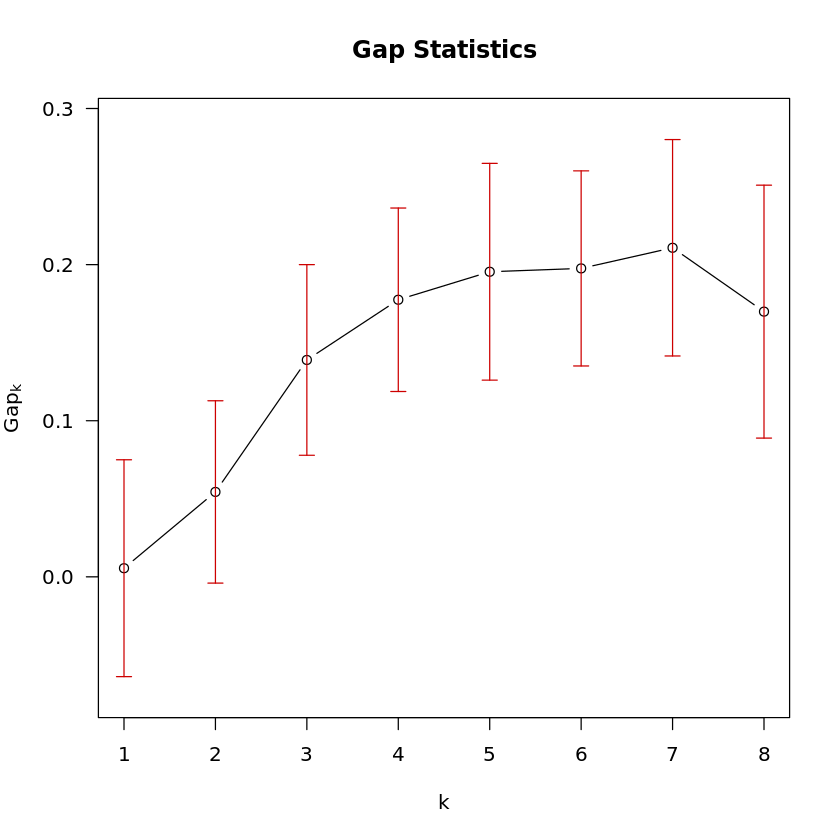

In [8]:
sc<- Clustexp(sc,cln=3,quiet=T,clustnr=8,rseed=17000)    
plotGap(sc)                                               ### Plotting gap statistics

#### Defining outlier cells based on K-means Clustering

Outlier identification is implemented using a background model based on distribution of transcript counts within a cluster. The background model is computed using the mean and the variance of the expression of each gene in a cluster. Outliers are defined as cells with a minimum of “outlg” outlier genes. Here we are setting the minimum number of outlier genes (the “outlg” parameter) to 5% of the number of filtered genes, this is based on the recommendation of De Vienne et al. (De Vienne et al., 2012). 

The following cells are considered outliers: 




named integer(0)


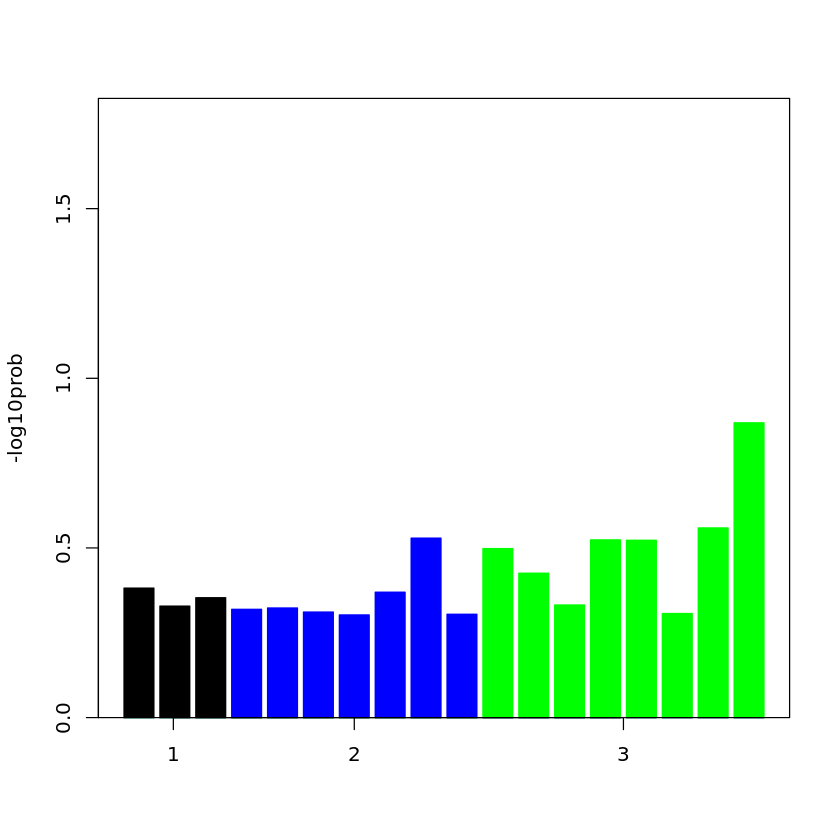

In [9]:
outlg<-round(length(sc@fdata[,1]) * 0.05)     # The cell will be considered as an outlier if it has a minimum of 5% of the number of filtered genes as outlier genes.
Outliers<- FindOutliers(sc, K=3, outminc=5,outlg=outlg,plot = TRUE, quiet = FALSE)

#### 2.1.2- Evaluating the stability and consistancy of the clusters

DIscBIO enables the robustness assessment of the detected clusters in terms of stability and consistency using Jaccard’s similarity statistics and silhouette coefficients. Jaccard’s similarity index provides a comparison of members among clusters to evaluate the stability of the clusters with a range from 0% to 100%. The higher the percentage, the more stable the cluster is. Silhouette coefficients estimate how close each sample in one cluster is to samples in the neighboring clusters, reflecting the consistency of each cluster with a range of [-1, 1]. The higher the cluster mean coefficient, the more consistent the cluster is.

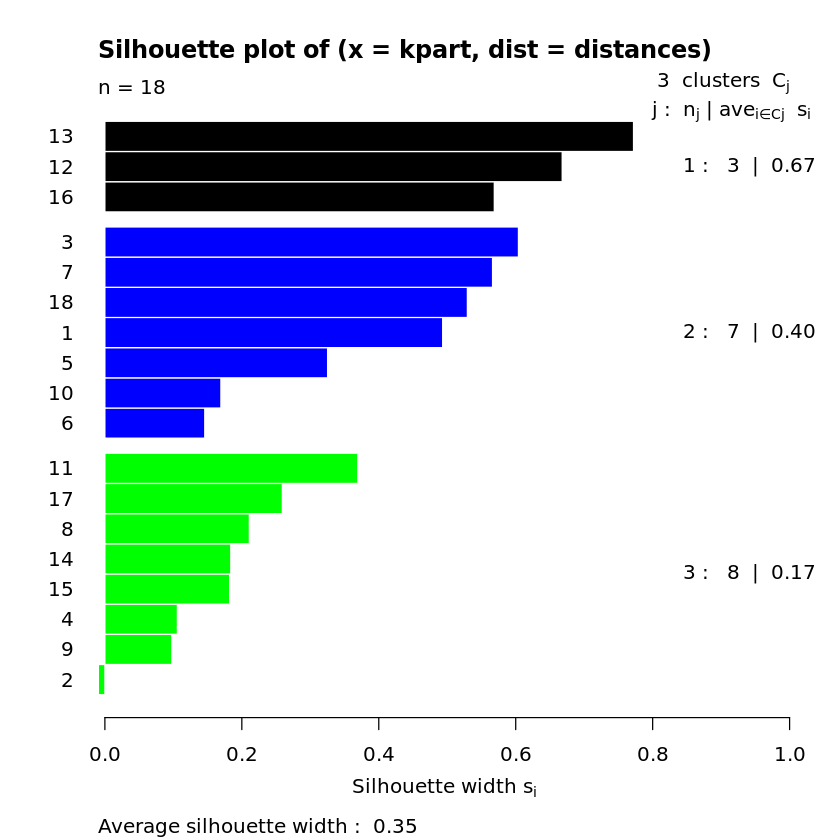

In [10]:
# Silhouette plot
plotSilhouette(sc,K=3)       # K is the number of clusters

[1] 0.623 0.364 0.363

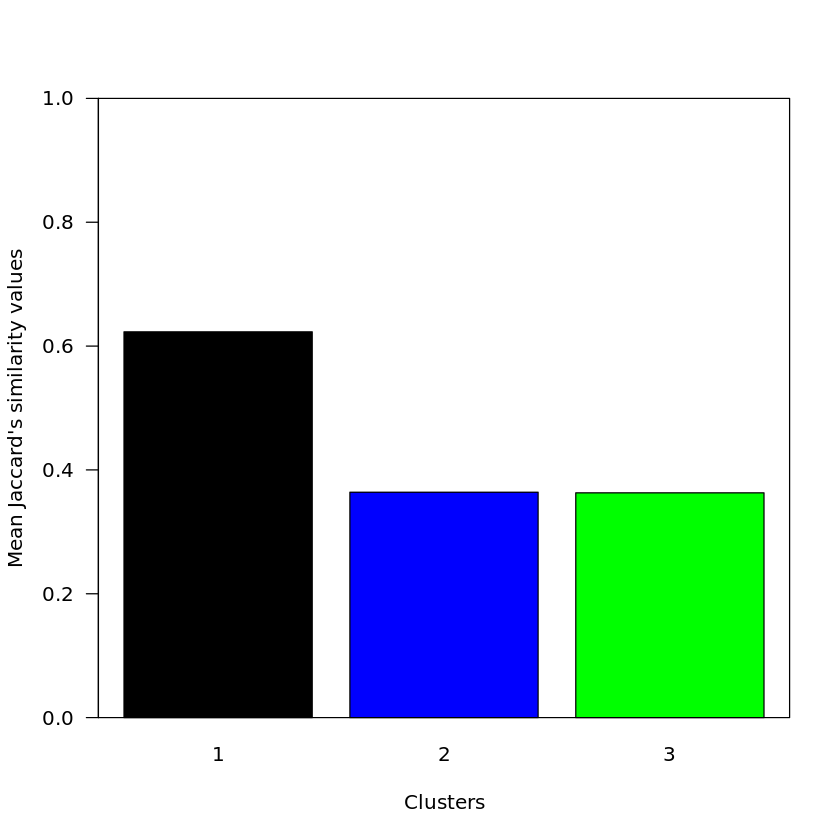

In [11]:
# Jaccard Plot
Jaccard(sc,Clustering="K-means", K=3, plot = TRUE)     # Jaccard 

#### 2.1.3. Cluster plotting using tSNE maps

Here you visualize the K-means clusters using t-distributed stochastic neighbor embedding (tSNE), which is a non-linear dimensionality reduction method that places neighbor cells close to each other. 

This function may take time

sigma summary: Min. : 33554432 |1st Qu. : 33554432 |Median : 33554432 |Mean : 33554432 |3rd Qu. : 33554432 |Max. : 33554432 |

Epoch: Iteration #500 error is: 0.386825821591046

Epoch: Iteration #1000 error is: 0.384437812270035

Epoch: Iteration #1500 error is: 0.384437805740511

Epoch: Iteration #2000 error is: 0.384437794799795

Epoch: Iteration #2500 error is: 0.384437780930006

Epoch: Iteration #3000 error is: 0.384437764367191

Epoch: Iteration #3500 error is: 0.384437744620368

Epoch: Iteration #4000 error is: 0.384437721116231

Epoch: Iteration #4500 error is: 0.384437693446411

Epoch: Iteration #5000 error is: 0.384437661303349



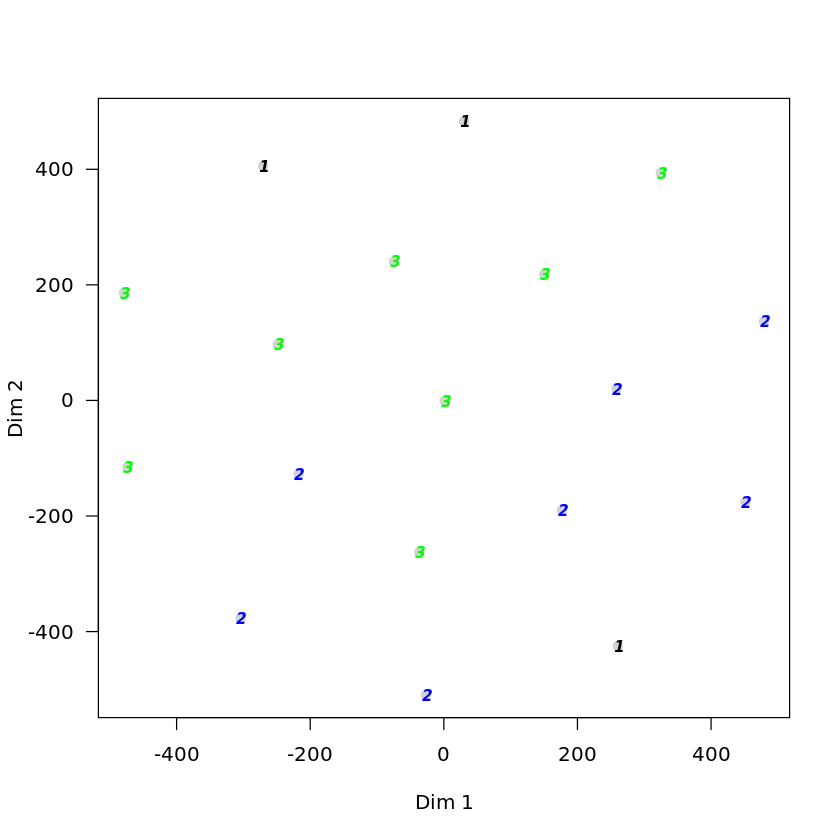

In [12]:
############ Plotting the clusters
sc<- comptSNE(sc,rseed=15555,quiet = F)
plottSNE(sc)

#### 2.1.4. Cellular pseudo-time ordering based on k-means clusters 

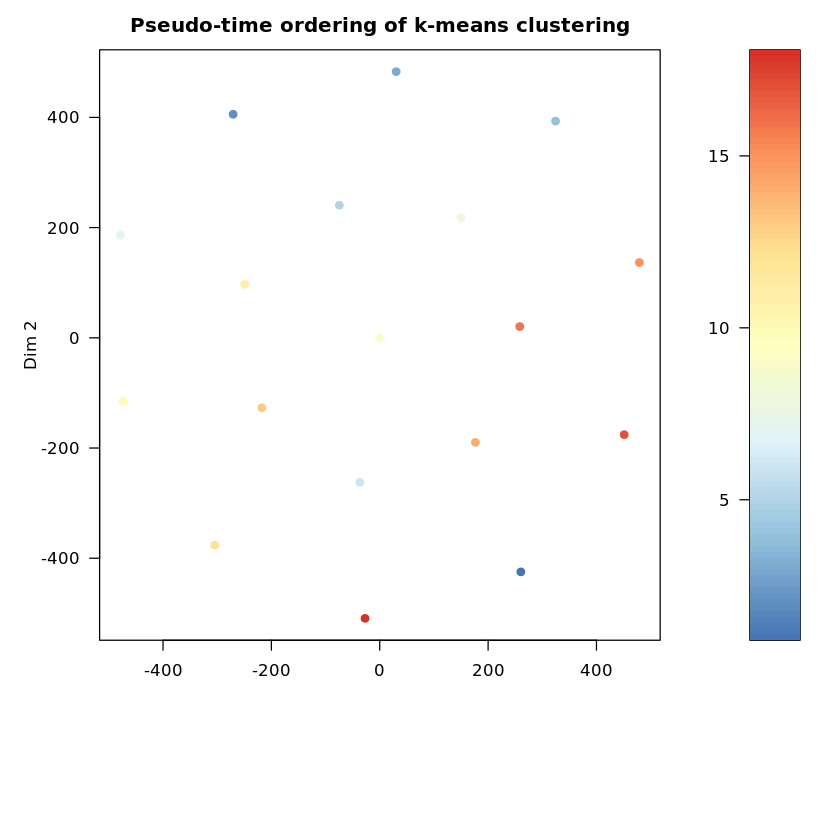

In [13]:
sc<-pseudoTimeOrdering(sc,quiet = TRUE, export = FALSE)
plotOrderTsne(sc)

[1] 1 2 3

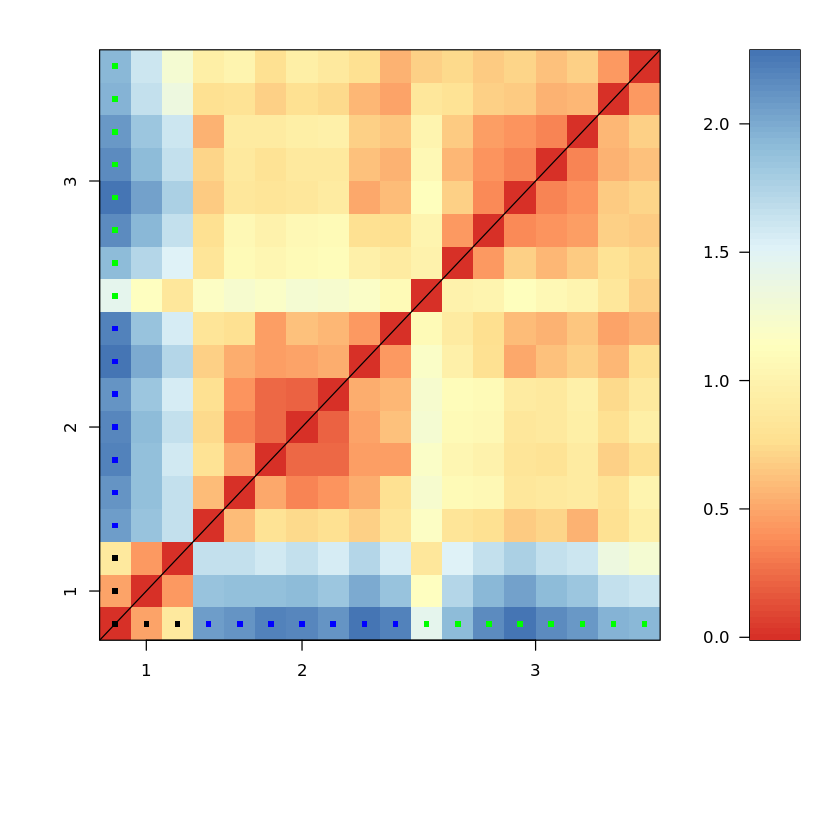

In [14]:
clustheatmap(sc)

#### 2.1.5 Plotting the gene expression of a particular gene in a tSNE map

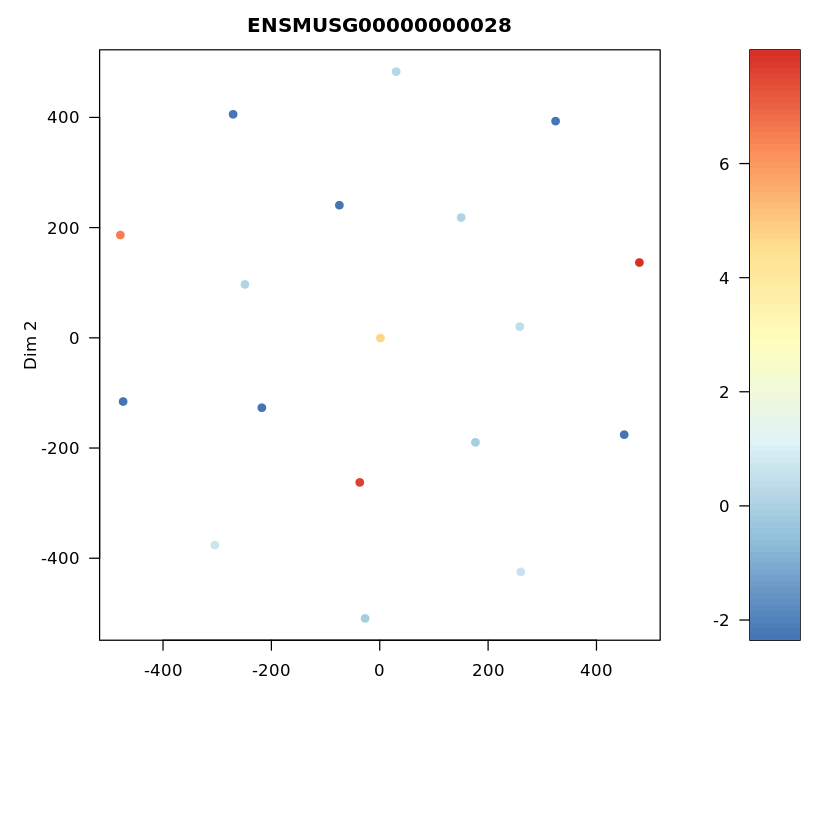

In [15]:
g='ENSMUSG00000000028'                   #### Plotting the log expression of  Cdc45
plotExptSNE(sc,g)

## 3. Determining differentially expressed genes (DEGs)

![DIsccBIO](KM2.png)

## 3.2 Identifying DEGs using binomial differential expression

The function ClustDiffGenes identifies differentially regulated genes for each cluster of the K-means clustering in 
comparison to the ensemble of all cells. It returns a list with a data.frame element for each cluster that contains the mean expression across all cells not in the cluster (mean.ncl) and in the cluster (mean.cl), the fold-change in the cluster versus all remaining cells (fc), and the p-value for differential expression between all cells in a cluster and all remaining cells. The p-value is computed based on the overlap of negative binomials fitted to the count distributions within the two groups akin to DESeq.

In [16]:
ClustDiff<-ClustDiffGenes(sc,K=3,export = T,pValue = 0.05,fdr = 0.001)
#### To show the result table
head(ClustDiff[[1]])                  # The first component 
head(ClustDiff[[2]])                  # The second component

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



DEGsE,DEGsS
ENSMUSG00000000001,ENSMUSG00000000001
ENSMUSG00000000028,ENSMUSG00000000028
ENSMUSG00000000056,ENSMUSG00000000056
ENSMUSG00000000058,ENSMUSG00000000058
ENSMUSG00000000078,ENSMUSG00000000078
ENSMUSG00000000085,ENSMUSG00000000085


,Target Cluster,VS,Gene number,File name,Gene number,File name
,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,Cluster 1,Remaining Clusters,5653,Up-DEG-cluster1.csv,5841,Down-DEG-cluster1.csv
2,Cluster 2,Remaining Clusters,3188,Up-DEG-cluster2.csv,5436,Down-DEG-cluster2.csv
3,Cluster 3,Remaining Clusters,3094,Up-DEG-cluster3.csv,4624,Down-DEG-cluster3.csv


### Plotting the DEGs

Volcano plots are used to readily show the DEGs by plotting significance versus fold-change on the y and x axes, respectively.

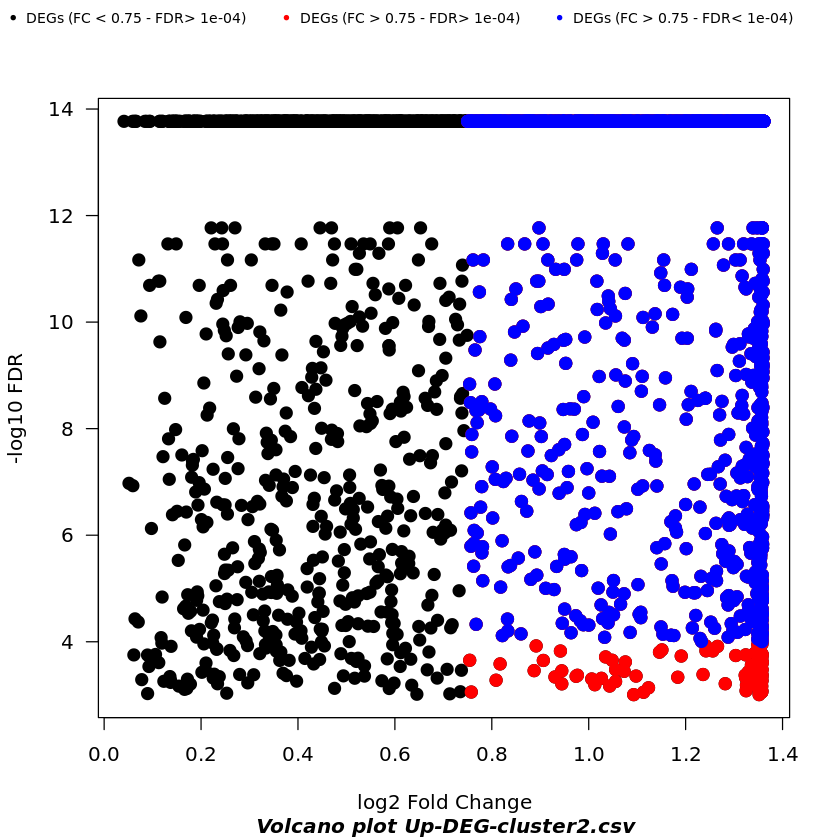

In [17]:
name<-ClustDiff[[2]][2,4]    ############ Selecting the "Up-DEG-cluster2.csv " from the DEGs' binomial table  ##############
U<-read.csv(file=paste0(name),head=TRUE,sep=",")
Vplot<-VolcanoPlot(U,value=0.0001,name=name,FS=0.7,fc=0.75)

## 4. Identifying biomarkers (decision trees and networking analysis) 

There are several methods to identify biomarkers, among them are decision trees and hub detection through networking analysis. The outcome of STRING analysis is stored in tab separated values (TSV) files. These TSV files served as an input to check both the connectivity degree and the betweenness centrality, which reflects the communication flow in the defined PPI networks 

![DIsccBIO](KM3.png)

Decision trees are one of the most efficient classification techniques in biomarkers discovery. Here we use it to predict the sub-population of a target cell based on transcriptomic data. Two types of decision trees can be performed: classification and regression trees (CART) and J48. The decision tree analysis is implemented over a training dataset, which consisted of the DEGs obtained by either SAMseq or the binomial differential expression. The performance of the generated trees can be evaluated for error estimation by ten-fold cross validation assessment using the "J48DTeval" and "RpartEVAL" functions. The decision tree analysis requires the dataset to be class vectored by applying the “ClassVectoringDT” function.

In [18]:
##########################################################   Creating a gene list that includes up regluated genes in cluster 2
DEGs=ClustDiff[[2]][2,4]                                   # UP-regulated genes in cluster 2 
data<-read.csv(file=paste0(DEGs),head=TRUE,sep=",")
sigDEG<-data[,1:2]
colnames(sigDEG)<-c("DEGsE","DEGsS")
#############################################################

First="CL2"
Second="CL3"
DATAforDT<-ClassVectoringDT(sc,Clustering="K-means",K=3,First=First,Second=Second,sigDEG)


The DEGs filtered normalized dataset contains:
Genes: 3188
cells: 15



### 4.1. J48 Decision Tree

J48 pruned tree
------------------

ENSMUSG00000021477 <= 17473.326946: CL3 (8.0)
ENSMUSG00000021477 > 17473.326946: CL2 (7.0)

Number of Leaves  : 	2

Size of the tree : 	3




=== Summary ===

Correctly Classified Instances          15              100      %
Incorrectly Classified Instances         0                0      %
Kappa statistic                          1     
Mean absolute error                      0     
Root mean squared error                  0     
Relative absolute error                  0      %
Root relative squared error              0      %
Total Number of Instances               15     

=== Confusion Matrix ===

 a b   <-- classified as
 7 0 | a = CL2
 0 8 | b = CL3

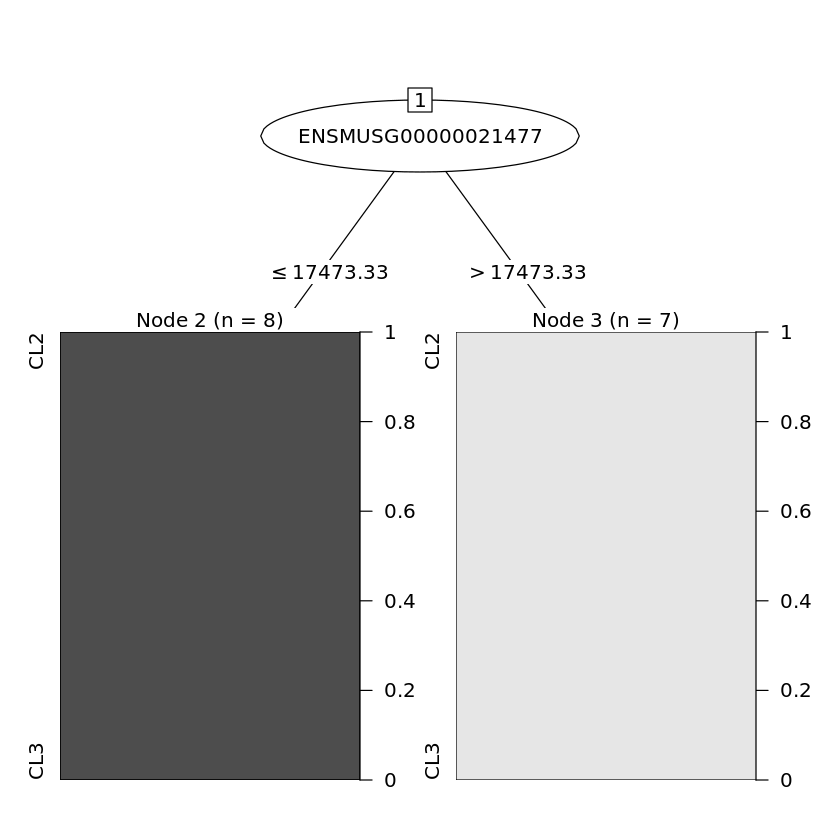

In [19]:
j48dt<-J48DT(DATAforDT)           #J48 Decision Tree
summary(j48dt) 
rm(j48dt)

#### 4.1.1. Evaluating the performance of the J48 Decision Tree

In [20]:
j48dt<-J48DTeval(DATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10

Fold 2 of 10

Fold 3 of 10

Fold 4 of 10

Fold 5 of 10

Fold 6 of 10

Fold 7 of 10

Fold 8 of 10

Fold 9 of 10

Fold 10 of 10



TP FN FP TN 
 3  4  3  5 
             CL2 CL3
PredictedCL2   3   3
PredictedCL3   4   5


J48 SN: 0.43
J48 SP: 0.62
J48 ACC: 0.53
J48 MCC: 0.05




### 4.2. RPART Decision Tree

n= 15 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 15 7 CL3 (0.4666667 0.5333333)  
  2) ENSMUSG00000021477>=20037.52 7 0 CL2 (1.0000000 0.0000000) *
  3) ENSMUSG00000021477< 20037.52 8 0 CL3 (0.0000000 1.0000000) *


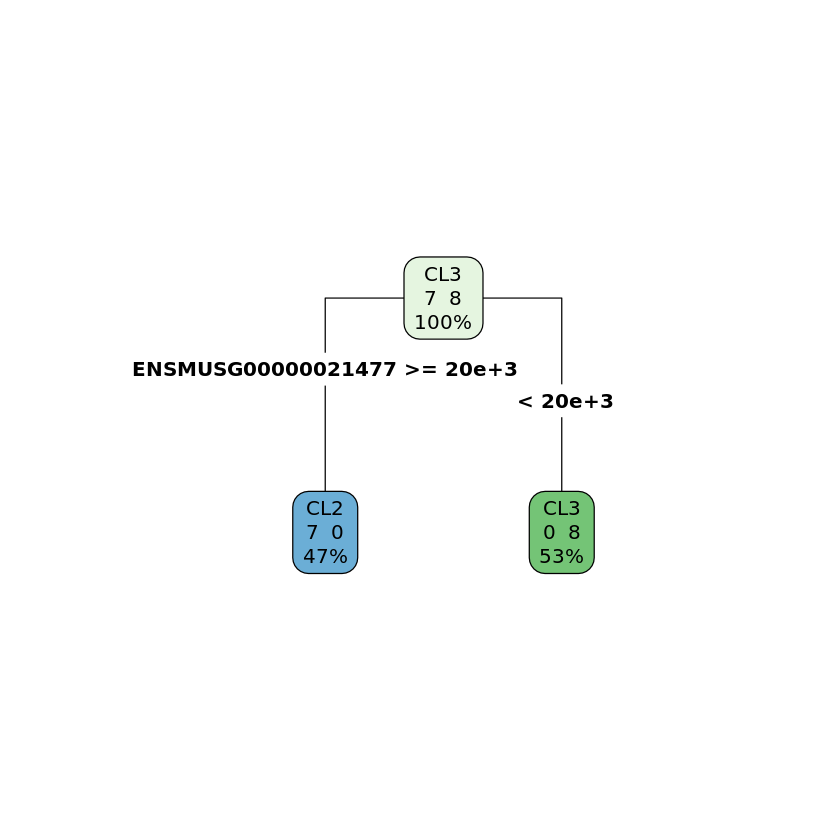

In [21]:
rpartDT<-RpartDT(DATAforDT)
rm(rpartDT)

#### 4.2.1. Evaluating the performance of the RPART Decision Tree

In [22]:
rpartEVAL<-RpartEVAL(DATAforDT,num.folds=10,First=First,Second=Second)

Fold 1 of 10

Fold 2 of 10

Fold 3 of 10

Fold 4 of 10

Fold 5 of 10

Fold 6 of 10

Fold 7 of 10

Fold 8 of 10

Fold 9 of 10

Fold 10 of 10



TP FN FP TN 
 0  7  5  3 
             CL2 CL3
PredictedCL2   0   5
PredictedCL3   7   3


Rpart SN: 0
Rpart SP: 0.38
Rpart ACC: 0.2
Rpart MCC: -0.66




### 4.3. Networking Analysis

In [23]:
DEGs="UP-regulated-cl2"
FileName=paste0(DEGs)
data<-ClustDiff[[1]] [1:300,2]             
ppi<-PPI(data,FileName,species = "10090")   ###### The Taxonomy ID of Mus musculus: 10090, it can be obtained from "https://www.ncbi.nlm.nih.gov/taxonomy"
ppi
networking<-NetAnalysis(ppi)
networking                            ##### In case the Examine response components = 200 and an error "linkmat[i, ]" appeared, that means there are no PPI.

Examine response components = 200	(200 means successful)



── Column specification ────────────────────────────────────────────────────────
cols(
  stringId_A = col_character(),
  stringId_B = col_character(),
  preferredName_A = col_character(),
  preferredName_B = col_character(),
  ncbiTaxonId = col_double(),
  score = col_double(),
  nscore = col_double(),
  fscore = col_double(),
  pscore = col_double(),
  ascore = col_double(),
  escore = col_double(),
  dscore = col_double(),
  tscore = col_double()
)




,stringId_A,stringId_B,preferredName_A,preferredName_B,ncbiTaxonId,score,nscore,fscore,pscore,ascore,escore,dscore,tscore
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10090.ENSMUSP00000000001,10090.ENSMUSP00000085906,Gnai3,Fmr1,10090,0.411,0,0,0,0.144,0.000,0.0,0.340
2,10090.ENSMUSP00000000001,10090.ENSMUSP00000085906,Gnai3,Fmr1,10090,0.411,0,0,0,0.144,0.000,0.0,0.340
3,10090.ENSMUSP00000000001,10090.ENSMUSP00000002532,Gnai3,Rgs19,10090,0.734,0,0,0,0.062,0.264,0.0,0.645
4,10090.ENSMUSP00000000001,10090.ENSMUSP00000002532,Gnai3,Rgs19,10090,0.734,0,0,0,0.062,0.264,0.0,0.645
5,10090.ENSMUSP00000000001,10090.ENSMUSP00000000153,Gnai3,Gna12,10090,0.906,0,0,0,0.060,0.050,0.9,0.445
6,10090.ENSMUSP00000000001,10090.ENSMUSP00000000153,Gnai3,Gna12,10090,0.906,0,0,0,0.060,0.050,0.9,0.445
7,10090.ENSMUSP00000000001,10090.ENSMUSP00000101236,Gnai3,Oprm1,10090,0.917,0,0,0,0.000,0.196,0.9,0.059
8,10090.ENSMUSP00000000001,10090.ENSMUSP00000101236,Gnai3,Oprm1,10090,0.917,0,0,0,0.000,0.196,0.9,0.059
9,10090.ENSMUSP00000000001,10090.ENSMUSP00000000574,Gnai3,Gpcr2,10090,0.928,0,0,0,0.000,0.251,0.9,0.124


Number of nodes: 241

Number of links: 539

Link Density: 2.23651452282158

The connectance of the graph: 0.00931881051175657

Mean Distences2.71239210850801

Average Path Length2.71239210850801




,names,degree,betweenness
,<chr>,<dbl>,<dbl>
77,Akt1,90,1337.30000
16,Pparg,34,178.50000
131,Timp1,32,49.86667
148,Rac1,32,117.68333
69,Col1a1,28,237.23333
163,Vwf,28,11.56667
11,Itgb2,26,0.00000
177,Nhp2,24,89.83333
107,Prpf6,22,91.91667


Examine response components =200	(200 means successful)


You can see the network with high resolution by clicking on the following link:
https://string-db.org/api/highres_image/network?identifiers=Akt1%0dPparg%0dTimp1%0dRac1%0dCol1a1%0dVwf%0dItgb2%0dNhp2%0dPrpf6%0dGtf2f1%0dMrpl2%0dAtp5d%0dApoe%0dRab5b%0dCrnkl1%0dSnrpd1%0dLamb1%0dAp2a2%0dTsc2%0dCol18a1%0dSdhd%0dRaf1%0dSec24b%0dAraf%0dOcrl%0dDdx18%0dSf3a1%0dClpp%0dYkt6%0dAp1m1%0dItga5%0dNdufa9%0dNdufb2%0dSmarcb1%0dItgb7%0dRab8a%0dPpp5c%0dFoxm1%0dMmp14%0dPuf60%0dKlf4%0dCd36%0dNgfr%0dCcnd2%0dPdgfb%0dRpa1%0dSnrnp27%0dUhrf1%0dCct3%0dPwp1%0dTrmt1%0dSnx9%0dBraf%0dLipe%0dIdh3g%0dFmr1%0dLman2l%0dRpl3l%0dHnrnpd%0dCdc45%0dHk2%0dS100a4%0dEfnb2%0dSmo%0dTrappc6a%0dSpi1%0dRhoc%0dDlat%0dSpag5%0dLcp2%0dStat6%0dGolga2%0dSpg7%0dDbf4%0dPfdn5%0dIft20%0dGnai3%0dTrappc10%0dRpl13%0dDdx3x%0dHip1r%0dOxa1l%0dTubb5%0dPpard%0dKdelr1%0dChaf1a%0dMap2k7%0dTimm44%0dStk11%0dAtp5f1%0dMov10%0dTiam1%0dKat2b%0dTubgcp3%0dPolr3d%0dPcnt%0dRnd2%0dMrpl10%0dNaglu%0dLtbp1&species

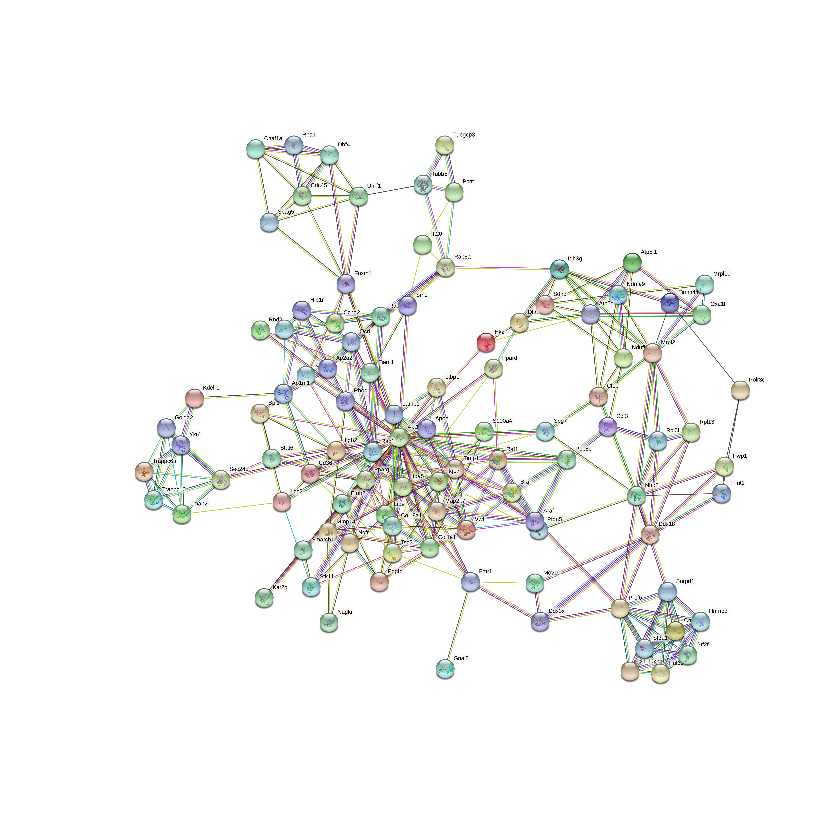

In [24]:
# Plotting the network of the top 100 hub DEGs
DATA<-networking[1:100,1]
network<-Networking(DATA,FileName,plot_width = 25, plot_height = 25,species = "10090")

### 4.4 Gene Enrichment Analysis

In [25]:
dbs <- listEnrichrDbs()
print(dbs)

    geneCoverage genesPerTerm                                       libraryName
1          13362          275                               Genome_Browser_PWMs
2          27884         1284                          TRANSFAC_and_JASPAR_PWMs
3           6002           77                         Transcription_Factor_PPIs
4          47172         1370                                         ChEA_2013
5          47107          509                  Drug_Perturbations_from_GEO_2014
6          21493         3713                           ENCODE_TF_ChIP-seq_2014
7           1295           18                                     BioCarta_2013
8           3185           73                                     Reactome_2013
9           2854           34                                 WikiPathways_2013
10         15057          300               Disease_Signatures_from_GEO_up_2014
11          4128           48                                         KEGG_2013
12         34061          641           

In [26]:
# Plotting the network of the top 100 hub DEGs
DATA<-networking[1:100,1]
#data<-as.character(data[,3])

dbs <- c("Mouse_Gene_Atlas", "WikiPathways_2019_Mouse","KEGG_2019_Mouse")
enriched <- enrichr(DATA, dbs)
Mouse_Gene_Atlas<-enriched[[1]][,c(1,2,3,9)]
Mouse_Gene_Atlas
WikiPathways_2019_Mouse<-enriched[[2]][,c(1,2,3,9)]
WikiPathways_2019_Mouse
KEGG_2019_Mouse<-enriched[[3]][,c(1,2,3,9)]
KEGG_2019_Mouse

Uploading data to Enrichr... Done.
  Querying Mouse_Gene_Atlas... Done.
  Querying WikiPathways_2019_Mouse... Done.
  Querying KEGG_2019_Mouse... Done.
Parsing results... Done.


Term,Overlap,P.value,Genes
<chr>,<chr>,<dbl>,<chr>
adipose brown,9/456,0.0004679829,NDUFA9;LIPE;IDH3G;CLPP;TIMM44;PPARG;SDHD;CD36;DLAT
heart,9/568,0.0021696878,NDUFA9;STK11;IDH3G;ATP5D;NDUFB2;SDHD;CD36;DLAT;ATP5F1
MEF,6/300,0.0039758784,EFNB2;CCND2;AKT1;LAMB1;ITGA5;LTBP1
3T3-L1,4/181,0.0129778521,SMO;FMR1;LAMB1;CRNKL1
embryonic stem line Bruce4 p13,9/876,0.0312366837,DDX18;SF3A1;CLPP;NHP2;RPA1;AKT1;PWP1;CRNKL1;PPARD
B-cells GL7 positive Alum,3/142,0.0344004257,DDX18;PUF60;HIP1R
osteoblast day5,3/175,0.0575615219,EFNB2;CCND2;TIMP1
embryonic stem line V26 2 p16,7/728,0.0724085501,DDX18;SF3A1;DBF4;UHRF1;POLR3D;NHP2;PWP1
macrophage peri LPS thio 7hrs,6/707,0.1429682477,MOV10;MMP14;SEC24B;LAMB1;ITGA5;RHOC


Term,Overlap,P.value,Genes
<chr>,<chr>,<dbl>,<chr>
Focal Adhesion WP85,13/185,8.370164e-12,VWF;ITGB2;ARAF;PDGFB;BRAF;LAMB1;COL1A1;CCND2;AKT1;ITGB7;RAC1;ITGA5;RAF1
Focal Adhesion-PI3K-Akt-mTOR-signaling pathway WP2841,14/324,8.176090e-10,NGFR;VWF;ITGB2;PDGFB;TSC2;LAMB1;COL1A1;LIPE;STK11;AKT1;ITGB7;ITGA5;RAF1;RAB8A
Integrin-mediated Cell Adhesion WP6,8/100,3.745824e-08,ITGB2;ARAF;AKT1;BRAF;ITGB7;RAC1;ITGA5;RAF1
MAPK signaling pathway WP493,7/159,1.514995e-05,PPP5C;PDGFB;AKT1;BRAF;RAC1;RAF1;MAP2K7
IL-3 Signaling Pathway WP373,5/100,1.460736e-04,SPI1;AKT1;STAT6;RAC1;RAF1
Insulin Signaling WP65,6/159,1.478970e-04,LIPE;AKT1;TSC2;RAC1;RAF1;MAP2K7
Electron Transport Chain WP295,5/103,1.678538e-04,NDUFA9;ATP5D;NDUFB2;SDHD;ATP5F1
Oxidative phosphorylation WP1248,4/62,2.627533e-04,NDUFA9;ATP5D;NDUFB2;ATP5F1
Dysregulated miRNA Targeting in Insulin/PI3K-AKT Signaling WP3855,3/26,2.900494e-04,COL1A1;CCND2;RAF1


Term,Overlap,P.value,Genes
<chr>,<chr>,<dbl>,<chr>
Focal adhesion,11/199,4.695656e-09,COL1A1;CCND2;VWF;PDGFB;AKT1;BRAF;ITGB7;LAMB1;RAC1;ITGA5;RAF1
PI3K-Akt signaling pathway,13/357,2.637477e-08,NGFR;VWF;PDGFB;TSC2;LAMB1;COL1A1;STK11;CCND2;AKT1;ITGB7;RAC1;ITGA5;RAF1
Rap1 signaling pathway,10/209,9.563640e-08,TIAM1;NGFR;ITGB2;PDGFB;GNAI3;AKT1;BRAF;LCP2;RAC1;RAF1
Pathways in cancer,14/535,4.347529e-07,SPI1;ARAF;PDGFB;GNAI3;BRAF;LAMB1;CCND2;SMO;AKT1;PPARG;STAT6;RAC1;RAF1;PPARD
Proteoglycans in cancer,9/203,8.206174e-07,COL1A1;TIAM1;SMO;ARAF;AKT1;BRAF;RAC1;ITGA5;RAF1
Renal cell carcinoma,6/68,1.143870e-06,ARAF;PDGFB;AKT1;BRAF;RAC1;RAF1
Acute myeloid leukemia,6/69,1.247776e-06,SPI1;ARAF;AKT1;BRAF;RAF1;PPARD
Regulation of actin cytoskeleton,9/217,1.428766e-06,TIAM1;ITGB2;ARAF;PDGFB;BRAF;ITGB7;RAC1;ITGA5;RAF1
Thermogenesis,9/231,2.392504e-06,NDUFA9;LIPE;SMARCB1;ATP5D;NDUFB2;TSC2;PPARG;SDHD;ATP5F1
